### Chest X-Ray (Pneumonia): Transfer Learning (b)

Using Several estandard models trained on Imagenet \
This example uses a ResNet152V2 network + some additional layers \
We train the new layers and some layers (19) from the original ResNet152V network 

Train accuracy 96% \
Val accuracy 96% \
Test accuracy 96% \
ROC 99%

 \
This notebook adds a balancing calculation in both variants \ 
We use adaptive learning rate as well

In [1]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to avoid warning messages

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

from keras.applications.resnet import ResNet152

import warnings
warnings.filterwarnings('ignore')

In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [3]:
# We shuffle the original dataset and create val and test more balanced (0,6 train, 0.2 test, 0.2 val)
# folder structure 
#Notebook
#    !------ chest_xray_data
#                  !-------------normal
#                  !-------------pneumonia

train_normal = glob.glob("./chest_xray_data/normal/*.jpeg")
train_pneumonia = glob.glob("./chest_xray_data/pneumonia/*.jpeg")
print('there are ',len(train_normal),'normal images and', len(train_pneumonia),'pneumonia images')
COUNT_PNEUMONIA = len(train_pneumonia)
COUNT_NORMAL = len(train_normal)

there are  1583 normal images and 4273 pneumonia images


In [4]:
all_list = [x for x in train_normal]
all_list.extend([x for x in train_pneumonia])

df_all = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), 
                      columns = ['class'])
df_all['image'] = [x for x in all_list]
print(df_all.shape)

(5856, 2)


In [5]:
train_df, dummy_df = train_test_split(df_all, test_size = 0.33, random_state = SEED, 
                                    stratify = df_all['class'])
test_df, val_df = train_test_split(dummy_df, test_size = 0.50, random_state = SEED, 
                                    stratify = dummy_df['class'])

print('train',train_df.shape, 'test', test_df.shape, 'val', val_df.shape)

train (3923, 2) test (966, 2) val (967, 2)


In [6]:
# to improve class balancing we calculate the weights to add to the training process

initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

calculated_class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 0.99299
Weight for class 0: 1.85
Weight for class 1: 0.69


### Data Preparation is performed in the same way as in previous notebooks

In [7]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(test_df,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 3923 validated image filenames belonging to 2 classes.
Found 967 validated image filenames belonging to 2 classes.
Found 966 validated image filenames belonging to 2 classes.


### Transfer Learning 
#### Model 1 - Adding new layers to previously trained network and training only the new ones

The second approach, called transfer learning, consists of using a pretrained model as a feature extractor. In this notebook, the selected model was the ResNet152V2 available on the Keras Package [(link)](https://keras.io/api/applications/. 

This model was already trained in another dataset (ImageNet). What we do here is to set include_top to false, removing the ‘head’, responsible for assigning the classes in this other dataset, and keep all the previous layers. Then, we include our last few layers, including the one responsible for generating the output.

We train only the new layers, leaving the ResNet152V2 network with the original Imagenet Training

In [8]:
#Setting callbakcs

initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=False
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0000001,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 10,                                   
    min_delt = 0.0000001,                                
    cooldown = 0,                               
    verbose = 1
) 

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [9]:
base_model = tf.keras.applications.ResNet152V2(      
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)
base_model.trainable = True

# Freeze all layers except for the last 19
for layer in base_model.layers[:-19]:
    layer.trainable = False

In [10]:
def get_trainable_network():
    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [11]:
# Check which layers are tuneable (trainable)
trainable_model = get_trainable_network()
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [12]:
# Careful if you use adaptive learning rate here, then it hits an error
lr_schedule = 0.0001
trainable_model.compile(loss='binary_crossentropy'
                 ,optimizer = keras.optimizers.Adam(learning_rate=lr_schedule), metrics='binary_accuracy')

trainable_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [13]:
history = trainable_model.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          class_weight = calculated_class_weight,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/50
122/122 [==============================] - 655s 5s/step - loss: 0.2167 - binary_accuracy: 0.9146 - val_loss: 0.1566 - val_binary_accuracy: 0.9504 - lr: 1.0000e-04
Epoch 2/50
122/122 [==============================] - 814s 7s/step - loss: 0.1131 - binary_accuracy: 0.9590 - val_loss: 0.0991 - val_binary_accuracy: 0.9576 - lr: 1.0000e-04
Epoch 3/50
122/122 [==============================] - 883s 7s/step - loss: 0.0955 - binary_accuracy: 0.9625 - val_loss: 0.1435 - val_binary_accuracy: 0.9483 - lr: 1.0000e-04
Epoch 4/50
122/122 [==============================] - 793s 6s/step - loss: 0.0774 - binary_accuracy: 0.9707 - val_loss: 0.1042 - val_binary_accuracy: 0.9576 - lr: 1.0000e-04
Epoch 5/50
122/122 [==============================] - 980s 8s/step - loss: 0.0784 - binary_accuracy: 0.9707 - val_loss: 0.1166 - val_binary_accuracy: 0.9638 - lr: 1.0000e-04
Epoch 6/50
122/122 [==============================] - 844s 7s/step - loss: 0.0777 - binary_accuracy: 0.9715 - val_loss: 0.1543 - v

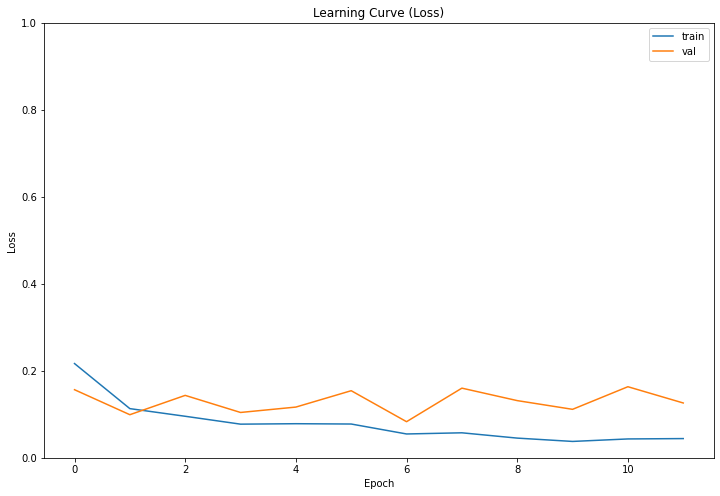

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 1)
ax.legend(['train', 'val'], loc='best')
plt.show()

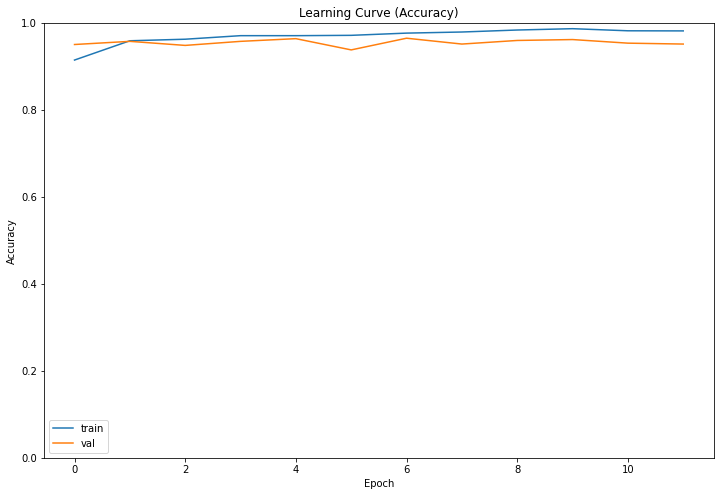

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.0, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [16]:
score = trainable_model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.0830298438668251
Val accuracy: 0.9648396968841553


In [17]:
score = trainable_model.evaluate(ds_test, steps = len(test_df), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.08442813903093338
Test accuracy: 0.9751552939414978


### Result Performance Evaluation</a> 

In [18]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = test_df['class'].copy().map(num_label).astype('int')

In [19]:
ds_test.reset()
predictions = trainable_model.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

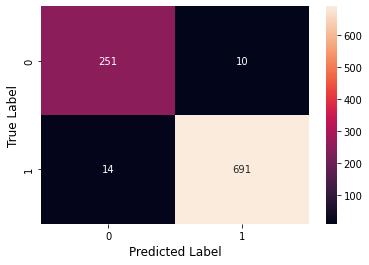

In [21]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [22]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       261
           1       0.99      0.98      0.98       705

    accuracy                           0.98       966
   macro avg       0.97      0.97      0.97       966
weighted avg       0.98      0.98      0.98       966



ROC_AUC:  0.9940653786581886


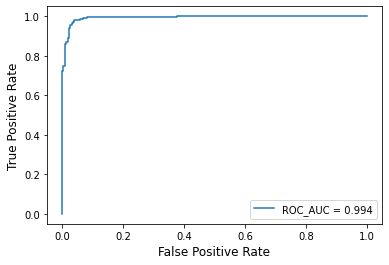

In [23]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()